# **Bank Customer Segmentation using RFM Analysis (Recency, Frequency, Monetary)**

*Hi everyone! This is my first ever notebook that I've posted on Kaggle. I'm excited to share my work with you all and I welcome any feedback or constructive criticism you may have. Thank you for taking the time to visit and explore my project!*

We have been provided with Bank Transactional Data and have conducted an RFM analysis to segment our customers and gain valuable insights. RFM itself stands for:
* Recency   (R) : How recently have they do a transaction?
* Frequency (F) : How often have they engage in bank transaction?
* Monetary  (M) : How much money do they involved in their transactions?
By analyzing these factors, we aim to develop targeted marketing strategies and enhance our understanding of customer behavior. Let's start exploring the data and examining the actionable insights gained from this analysis.

First, we import the data.

# **Import Data**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plots and visualization
import scipy.stats as stats # scientific computing tools
pd.set_option('mode.chained_assignment', None)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-customer-segmentation/bank_transactions.csv


In [2]:
df = pd.read_csv('/kaggle/input/bank-customer-segmentation/bank_transactions.csv')

# Showing preview of the Data (top 5 rows)
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


# **Data Dictionary**

|Field                          |Description |
|:------------------------------|:-----------|
|TransactionID                  | A unique identifier for each transaction |
|CustomerID                     | A unique identifier for each customer who do the transaction |
|CustomerDOB                    | The date of birth of customer | 
|CustGender                     | The gender of the customer|
|CustLocation                   | The location when the customer making transaction|
|CustAccountBalance             | The account balance of the customer, indicating the amount of money held in their bank account|
|TransactionDate                | The date on which the transaction occurred|
|Transaction Time               | The time on which the transaction occurred|
|TransactionAmount (INR)        | The monetary value of each transaction in Indian Rupees (INR)|

# **Pre Analysis**
Before we do the RFM analysis, let's begin with data preparation such as cleaning, transformation, and exploratory data analysis.

In [3]:
# Checking the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


'TransactionTime' is not quite necessary for the analysis (since we already have 'TransactionDate' column). <br>
Let's drop it.

In [4]:
# Drop 'TransactionTime' column
df = df.drop(columns = 'TransactionTime')

# Check the columns list
df.columns

Index(['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionAmount (INR)'],
      dtype='object')

We also found that 'CustomerDOB' and 'invoice_date' column data type isn't assigned to the correct data type so let's change it to datetime type.

In [5]:
# Convert the data type
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format='%d/%m/%y', errors = 'coerce')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Check the data information again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1048567 non-null  object        
 1   CustomerID               1048567 non-null  object        
 2   CustomerDOB              987831 non-null   datetime64[ns]
 3   CustGender               1047467 non-null  object        
 4   CustLocation             1048416 non-null  object        
 5   CustAccountBalance       1046198 non-null  float64       
 6   TransactionDate          1048567 non-null  datetime64[ns]
 7   TransactionAmount (INR)  1048567 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 64.0+ MB


We also want to see how many missing value (in percentage) of each columns

In [6]:
# Null and Not-Null Comparison
pd.DataFrame({
    'null-count': df.isna().sum(),
    'not-null-count': df.notna().sum(),
    'pct-null': df.isna().sum()/len(df)*100
})

,null-count,not-null-count,pct-null
TransactionID,0,1048567,0.000000
CustomerID,0,1048567,0.000000
CustomerDOB,60736,987831,5.792286
CustGender,1100,1047467,0.104905
CustLocation,151,1048416,0.014401
CustAccountBalance,2369,1046198,0.225927
TransactionDate,0,1048567,0.000000
TransactionAmount (INR),0,1048567,0.000000


There is some missing values in 'CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance'. I think it is okay to just let the first three columns that I state remain as that since our goal is doing a customer segmentation based on their RFM. The problem is the missing values in 'CustAccountBalance' column is a bit tricky to handle yet too inconvenience to be included in analysis. Since it is only 0.23% of the entire data, I decided to drop the rows.

In [7]:
# Drop the rows that have missing values in 'CustAccountBalance' column
df.dropna(subset=['CustAccountBalance'], inplace=True)

# Verify that the rows with missing values have been dropped
df.isna().sum()

TransactionID                  0
CustomerID                     0
CustomerDOB                60561
CustGender                  1100
CustLocation                 151
CustAccountBalance             0
TransactionDate                0
TransactionAmount (INR)        0
dtype: int64

Now, let's see the number comparison of unique values and total count of each column.

In [8]:
# Number Comparison of Unique Values and Total Count of each column
pd.DataFrame({
    'unique_count':df.nunique(),
    'rows_count':df.count()
})

,unique_count,rows_count
TransactionID,1046198,1046198
CustomerID,882600,1046198
CustomerDOB,17233,985637
CustGender,3,1045098
CustLocation,9330,1046047
CustAccountBalance,161328,1046198
TransactionDate,55,1046198
TransactionAmount (INR),92855,1046198


That looks nice! Next, we should know the data distribution

In [9]:
# Descriptive Statistics for quantitative variables
df.describe()

,CustAccountBalance,TransactionAmount (INR)
count,1.046198e+06,1.046198e+06
mean,1.154035e+05,1.573267e+03
std,8.464854e+05,6.569715e+03
min,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.610000e+02
50%,1.679218e+04,4.590000e+02
75%,5.765736e+04,1.200000e+03
max,1.150355e+08,1.560035e+06


In [10]:
# Descriptive Statistics for categorical variables
df.describe(include='object')

,TransactionID,CustomerID,CustGender,CustLocation
count,1046198,1046198,1045098,1046047
unique,1046198,882600,3,9330
top,T1,C5531319,M,MUMBAI
freq,1,6,763825,103325


In [11]:
# Descriptive Statistics for datetime variables
pd.DataFrame({
    'CustomerDOB': df['CustomerDOB'].describe(datetime_is_numeric=True),
    'TransactionDate': df['TransactionDate'].describe(datetime_is_numeric=True)
})

,CustomerDOB,TransactionDate
count,985637,1046198
mean,1990-12-21 21:43:37.027972736,2016-07-25 19:41:48.174552064
min,1969-01-01 00:00:00,2016-01-08 00:00:00
25%,1983-09-08 00:00:00,2016-06-09 00:00:00
50%,1988-08-06 00:00:00,2016-08-20 00:00:00
75%,1992-02-10 00:00:00,2016-09-09 00:00:00
max,2068-12-31 00:00:00,2016-12-09 00:00:00


Here we found an anomaly, how can we have a customer that born in the future for transaction in 2016? There are probably some data entry mistake happened. Let's check it first how is the data distribution that have this anomaly.

In [12]:
# Descriptive Statistics for 'CustomerDOB' anomaly data
df['CustomerDOB'][df['CustomerDOB'] > max(df['TransactionDate'])].describe(datetime_is_numeric=True)

count                            54307
mean     2059-12-31 01:26:39.241350144
min                2018-05-03 00:00:00
25%                2055-04-29 00:00:00
50%                2062-05-31 00:00:00
75%                2066-04-11 00:00:00
max                2068-12-31 00:00:00
Name: CustomerDOB, dtype: object

There is 54307 rows so let's do some value replacing. When we want to fill some missing/unknown values in datetime type of column, we tends to use backward or forward filling. But knowing that it is a DOB, I personally think we should fill it with either median or mean instead. This approach ensures consistency in the data while preserving the integrity of the birth date information. <br>
To decide whether to use median or mean, let's take a look for their distribution first.

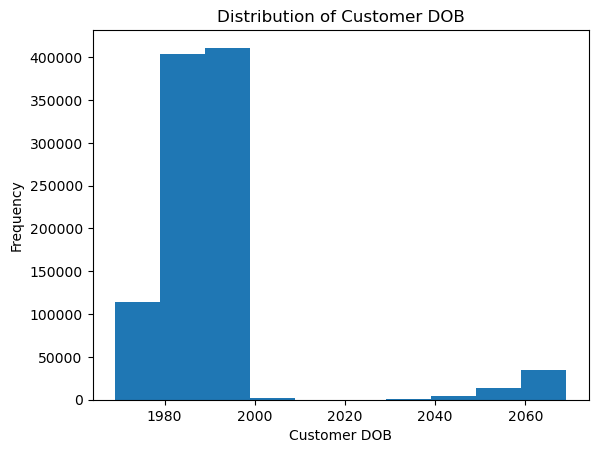

In [13]:
# Histogram of 'CustomerDOB' column
plt.hist(df['CustomerDOB'])
plt.xlabel('Customer DOB')
plt.ylabel('Frequency')
plt.title('Distribution of Customer DOB')
plt.show()

We see that the distribution is right skewed, therefor it will be better for us to use median.

In [14]:
# Replace the anomaly 'CustomerDOB' with the median value of 'CustomerDOB' (1989-01-01)
df['CustomerDOB'][df['CustomerDOB'] > max(df['TransactionDate'])] = pd.to_datetime('1988-08-06 00:00:00')

# Verify that the anomaly data have been replaced
df[df['CustomerDOB'] > max(df['TransactionDate'])]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR)


Since Anomaly is cleared, we can continue to do some exploratory data analysis focused on data visualization to understand our data better. <br>
We want to know how distributed the value of our quantitative columns. Since the data has a wide range with large values, I decided to apply a logarithmic transformation which can help compress the scale and reveal more details in the lower range.

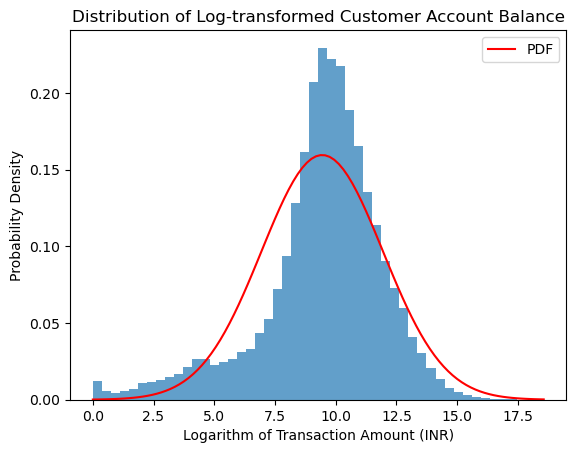

In [15]:
# Histogram of CustAccountBalance column
log_balance = np.log1p(df['CustAccountBalance'])

plt.hist(log_balance, bins=50, density=True, alpha=0.7)
plt.xlabel('Logarithm of Transaction Amount (INR)')
plt.ylabel('Probability Density')
plt.title('Distribution of Log-transformed Customer Account Balance')
x = np.linspace(log_balance.min(), log_balance.max(), 100)
dist = stats.norm(log_balance.mean(), log_balance.std())
plt.plot(x, dist.pdf(x), color='red', label='PDF')
plt.legend()
plt.show()

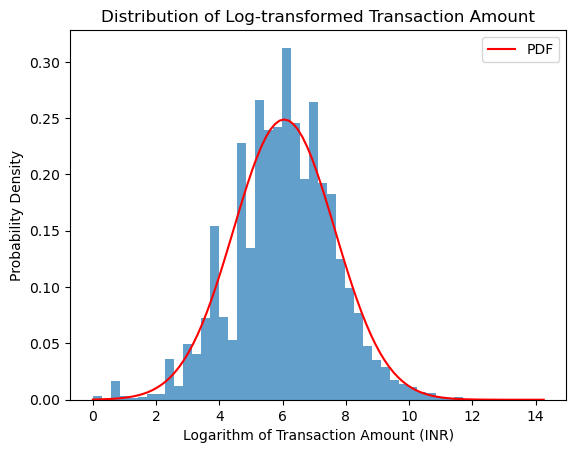

In [16]:
# Histogram of 'TransactionAmount (INR)' column
log_trx_amount = np.log1p(df['TransactionAmount (INR)'])

plt.hist(log_trx_amount, bins=50, density=True, alpha=0.7)
plt.xlabel('Logarithm of Transaction Amount (INR)')
plt.ylabel('Probability Density')
plt.title('Distribution of Log-transformed Transaction Amount')
x = np.linspace(log_trx_amount.min(), log_trx_amount.max(), 100)
dist = stats.norm(log_trx_amount.mean(), log_trx_amount.std())
plt.plot(x, dist.pdf(x), color='red', label='PDF')
plt.legend()
plt.show()

It actually looks normally distributed.
Now we should continue with other visualization, let's look for customer's gender distribution. 

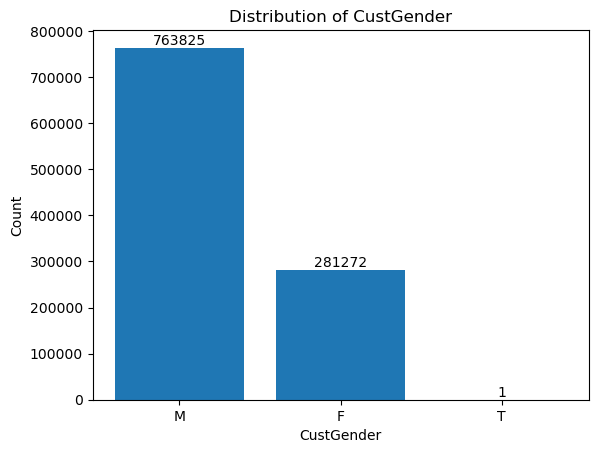

In [17]:
# Bar Plot for 'CustGender' column
gender_counts = df['CustGender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('CustGender')
plt.ylabel('Count')
plt.title('Distribution of CustGender')

# Add labels to the bars
for i, count in enumerate(gender_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

We can see that we mostly have Male Customer and there is possibly some mistyping since we have only one 'T' gender listed in the data. Let's replace it with 'M', the most frequent gender from our customers.

In [18]:
# Replace the anomaly 'CustomerDOB' with the most frequent CustomerDOB (1989-01-01)
df['CustGender'][df['CustGender'] == 'T'] = 'M'

# Verify that the data have been replaced
df['CustGender'].value_counts()

M    763826
F    281272
Name: CustGender, dtype: int64

Last EDA! Let's make a line chart or time series plot to understand our transaction trend better.

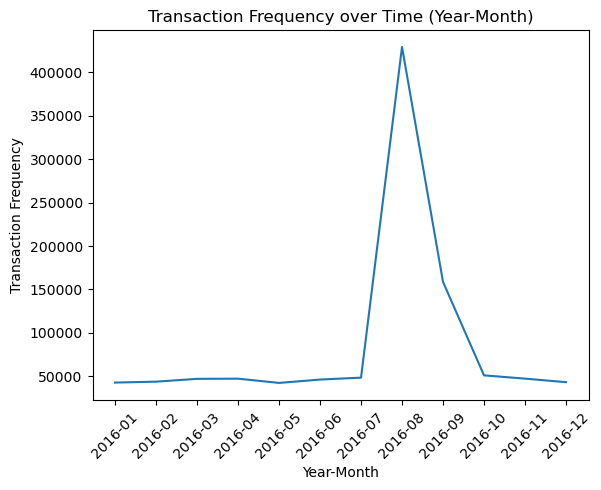

In [19]:
# Time series plot for transaction frequency over time (year-month)

# Grouping TransactionDate column to YearMonth
df['YearMonth'] = df['TransactionDate'].dt.to_period('M').astype(str)
transactions_count = df.groupby('YearMonth')['TransactionID'].count()

plt.plot(transactions_count.index, transactions_count.values)
plt.xlabel('Year-Month')
plt.ylabel('Transaction Frequency')
plt.title('Transaction Frequency over Time (Year-Month)')
plt.xticks(rotation=45)
plt.show()

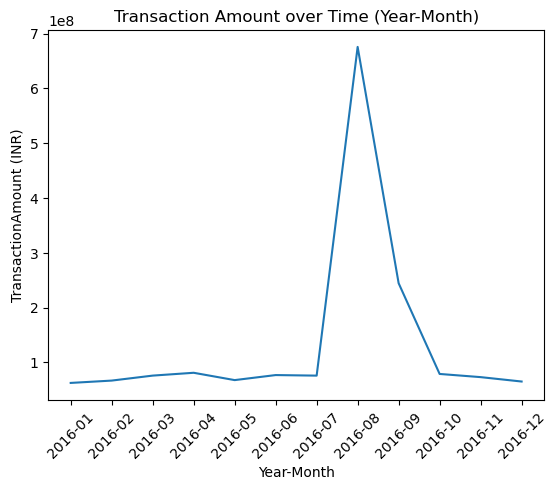

In [20]:
# Time series plot for transactions amount over time (year-month)
monthly_trx_amount = df.groupby('YearMonth')['TransactionAmount (INR)'].sum()

plt.plot(monthly_trx_amount.index, monthly_trx_amount.values)
plt.xlabel('Year-Month')
plt.ylabel('TransactionAmount (INR)')
plt.title('Transaction Amount over Time (Year-Month)')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Detailed Table of Transaction Happened
transactions_count.reset_index().rename(columns={'TransactionID': 'TransactionCount'}).merge(monthly_trx_amount.reset_index().rename(columns={'TransactionAmount (INR)': 'TotalMonetaryAmount'}), on='YearMonth')

,YearMonth,TransactionCount,TotalMonetaryAmount
0,2016-01,42638,6.271797e+07
1,2016-02,43683,6.697682e+07
2,2016-03,46926,7.606330e+07
3,2016-04,47132,8.122507e+07
4,2016-05,42233,6.785720e+07
5,2016-06,46110,7.704868e+07
6,2016-07,48299,7.602820e+07
7,2016-08,429294,6.757512e+08
8,2016-09,158650,2.446302e+08
9,2016-10,50949,7.908596e+07


Turns out we have some massive transactions happened in august and september 2016! It is advisable for the bank to conduct further investigation to understand the underlying reasons behind the sudden spike in transactions during August and September 2016.

# **RFM Analysis for Customer Segmentation**
We have finished the pre analysis needed, so let's jump to RFM analysis. First, let's take a brief look again in our data

In [22]:
# Check the data
df.sample()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionAmount (INR),YearMonth
678077,T678078,C6640041,1990-03-18,M,SONIPAT,27728.68,2016-08-31,50.0,2016-08


In [23]:
df.shape

(1046198, 9)

We know that we also analyze the recency of each user, so let's set our today to the last date listed in 'TransactionDate' column.

In [24]:
# Set 'today' variable
today = max(df['TransactionDate'])

Next step, we need to create a new table that will store the user details specifically for this analysis. The purpose of this new table is to provide a streamlined and structured format for conducting the RFM analysis.

In [25]:
# Creating 'dfUser' table
dfUser = df.groupby('CustomerID', as_index=False).agg(TransactionCount=('TransactionID','nunique'),LastTransactionDate=('TransactionDate','max'),TotalTransactionValue=('TransactionAmount (INR)','sum'))
dfUser.head()

,CustomerID,TransactionCount,LastTransactionDate,TotalTransactionValue
0,C1010011,2,2016-09-26,5106.0
1,C1010012,1,2016-08-14,1499.0
2,C1010014,2,2016-07-08,1455.0
3,C1010018,1,2016-09-15,30.0
4,C1010024,1,2016-08-18,5000.0


Then, we create a new column specifically to calculate how many day user had their last transaction.

In [26]:
dfUser['DaySinceLastTransaction'] = (today - dfUser['LastTransactionDate']).dt.days
dfUser.head()

,CustomerID,TransactionCount,LastTransactionDate,TotalTransactionValue,DaySinceLastTransaction
0,C1010011,2,2016-09-26,5106.0,74
1,C1010012,1,2016-08-14,1499.0,117
2,C1010014,2,2016-07-08,1455.0,154
3,C1010018,1,2016-09-15,30.0,85
4,C1010024,1,2016-08-18,5000.0,113


Nice! Let's do some reindex column to make our 'dfUser' more summarize, then we will take a look for their descriptive statistics.

In [27]:
# Reindex 'dfUser columns'
dfUser = dfUser.reindex(columns=['CustomerID', 'DaySinceLastTransaction', 'TransactionCount', 'TotalTransactionValue'])
dfUser.head()

,CustomerID,DaySinceLastTransaction,TransactionCount,TotalTransactionValue
0,C1010011,74,2,5106.0
1,C1010012,117,1,1499.0
2,C1010014,154,2,1455.0
3,C1010018,85,1,30.0
4,C1010024,113,1,5000.0


In [28]:
# Descriptive Statistics of dfUser (without RFM score)
dfUser.describe()

,DaySinceLastTransaction,TransactionCount,TotalTransactionValue
count,882600.000000,882600.000000,8.826000e+05
mean,128.744488,1.185359,1.864886e+03
std,80.025715,0.450060,7.200223e+03
min,0.000000,1.000000,0.000000e+00
25%,86.000000,1.000000,2.000000e+02
50%,109.000000,1.000000,5.360000e+02
75%,153.000000,1.000000,1.500000e+03
max,336.000000,6.000000,1.560035e+06


To create the RFM score, we start by binning the data for Recency (based on 'DaySinceLastTransaction'), Frequency (based on 'TransactionCount'), and Monetary Value (based on 'TotalTransactionValue') using the rules below:
* The lower 'DaySinceLastTransaction' value indicates higher recency score (better recency), while higher 'TransactionCount' and 'TotalTransactionValue' values indicate higher frequency and monetary score, respectively.
* Recency: The bins will be determined using percentiles: the 0th, 20th, 40th, 60th, 80th, and 100th percentiles. This allows us to divide the values into five equal-sized bins or intervals. The label binning will be [5, 4, 3, 2, 1]
* Frequency: Through the descriptive statistics we do before, it is revealed that the 'TransactionCount' distribution is highly skewed towards 1. For this reason, we won't use percentiles, instead we use these rules:
  * 1: Customers with a transaction count of 1 or 2
  * 2: Customers with a transaction count of 3 or 4
  * 3: Customers with a transaction count of more than 4
* Monetary: The bins will be determined using percentiles: the 0th, 20th, 40th, 60th, 80th, and 100th percentiles. This allows us to divide the values into five equal-sized bins or intervals. The label binning will be [1, 2, 3, 4, 5]


In [29]:
# Data Binning for Recency Score
dfUser['Recency Score'] = pd.qcut(dfUser['DaySinceLastTransaction'], 5, labels=[5, 4, 3, 2, 1])
# Data Binning for Frequency Score
dfUser['Frequency Score'] = pd.cut(dfUser['TransactionCount'], bins=[0, 2, 4, dfUser['TransactionCount'].max()+1], labels=[1, 2, 3])
# Data Binning for Monetary Score
dfUser['Monetary Score']= pd.qcut(dfUser['TotalTransactionValue'],5,labels=[1,2,3,4,5])

dfUser.head()

,CustomerID,DaySinceLastTransaction,TransactionCount,TotalTransactionValue,Recency Score,Frequency Score,Monetary Score
0,C1010011,74,2,5106.0,5,1,5
1,C1010012,117,1,1499.0,2,1,4
2,C1010014,154,2,1455.0,2,1,4
3,C1010018,85,1,30.0,4,1,1
4,C1010024,113,1,5000.0,3,1,5


In [30]:
# Make a 'RFM_Score' column to make the segmentation easier
dfUser['RFM_Score'] = (dfUser['Recency Score'].astype(str)) + (dfUser['Frequency Score'].astype(str)) + (dfUser['Monetary Score'].astype(str))
dfUser.head()

,CustomerID,DaySinceLastTransaction,TransactionCount,TotalTransactionValue,Recency Score,Frequency Score,Monetary Score,RFM_Score
0,C1010011,74,2,5106.0,5,1,5,515
1,C1010012,117,1,1499.0,2,1,4,214
2,C1010014,154,2,1455.0,2,1,4,214
3,C1010018,85,1,30.0,4,1,1,411
4,C1010024,113,1,5000.0,3,1,5,315


Very good! Now let's continue to user segmentation. I decided to focus on Recency and Frequency which are two fundamental factors that directly reflect customer behavior and loyality with the bank. While Monetary is also an important component, it may not always be the primary driver of customer behavior in the banking context. By temporarily excluding Monetary score, we will be able to create more straightforward and actionable segments that are easier to interpret and implement in marketing strategies.

In [31]:
# User Segmentation
segment_map = {
    r'[4-5]3.': 'High Recency, High Frequency',
    r'[4-5]2.': 'High Recency, Medium Frequency',
    r'[4-5]1.': 'High Recency, Low Frequency',
    r'[2-3]3.': 'Medium Recency, High Frequency',
    r'[2-3]2.': 'Medium Recency, Medium Frequency',
    r'[2-3]1.': 'Medium Recency, Low Frequency',
    r'13.': 'Low Recency, High Frequency',
    r'12.': 'Low Recency, Medium Frequency',
    r'11.': 'Low Recency, Low Frequency'
}

dfUser['Customer Segment'] = dfUser['RFM_Score'].replace(segment_map, regex=True)
dfUser.head()


,CustomerID,DaySinceLastTransaction,TransactionCount,TotalTransactionValue,Recency Score,Frequency Score,Monetary Score,RFM_Score,Customer Segment
0,C1010011,74,2,5106.0,5,1,5,515,"High Recency, Low Frequency"
1,C1010012,117,1,1499.0,2,1,4,214,"Medium Recency, Low Frequency"
2,C1010014,154,2,1455.0,2,1,4,214,"Medium Recency, Low Frequency"
3,C1010018,85,1,30.0,4,1,1,411,"High Recency, Low Frequency"
4,C1010024,113,1,5000.0,3,1,5,315,"Medium Recency, Low Frequency"


In [32]:
# Verify if there is no CustomerID that segmented in more than one customer segment
dfUser[dfUser.duplicated(subset='CustomerID')]

,CustomerID,DaySinceLastTransaction,TransactionCount,TotalTransactionValue,Recency Score,Frequency Score,Monetary Score,RFM_Score,Customer Segment


In [33]:
# Verify that there is no column have missing values
dfUser.isna().sum()

CustomerID                 0
DaySinceLastTransaction    0
TransactionCount           0
TotalTransactionValue      0
Recency Score              0
Frequency Score            0
Monetary Score             0
RFM_Score                  0
Customer Segment           0
dtype: int64

It's finished! Let's do some quick summary. Here I made a pivot table that showing the average value of R, F, M criteria, and then followed by the bar chart of the customer counts.

In [34]:
dfUserSummary = pd.pivot_table(dfUser,
                               index='Customer Segment', 
                               values=['CustomerID', 'DaySinceLastTransaction', 'TransactionCount', 'TotalTransactionValue'], 
                               aggfunc={'CustomerID': 'count',
                                        'DaySinceLastTransaction': 'mean',
                                        'TransactionCount': 'mean', 
                                        'TotalTransactionValue': 'sum'}
                              )
dfUserSummary

,CustomerID,DaySinceLastTransaction,TotalTransactionValue,TransactionCount
Customer Segment,,,,
"High Recency, High Frequency",144,52.569444,1.311777e+06,5.090278
"High Recency, Low Frequency",356623,69.168088,6.668882e+08,1.214170
"High Recency, Medium Frequency",14055,61.084027,6.817628e+07,3.103024
"Low Recency, Low Frequency",163007,273.644801,2.691605e+08,1.034551
"Low Recency, Medium Frequency",156,240.346154,5.485778e+05,3.025641
"Medium Recency, High Frequency",15,110.866667,1.346080e+05,5.066667
"Medium Recency, Low Frequency",344449,124.759851,6.193719e+08,1.123458
"Medium Recency, Medium Frequency",4151,115.217297,2.035677e+07,3.057095


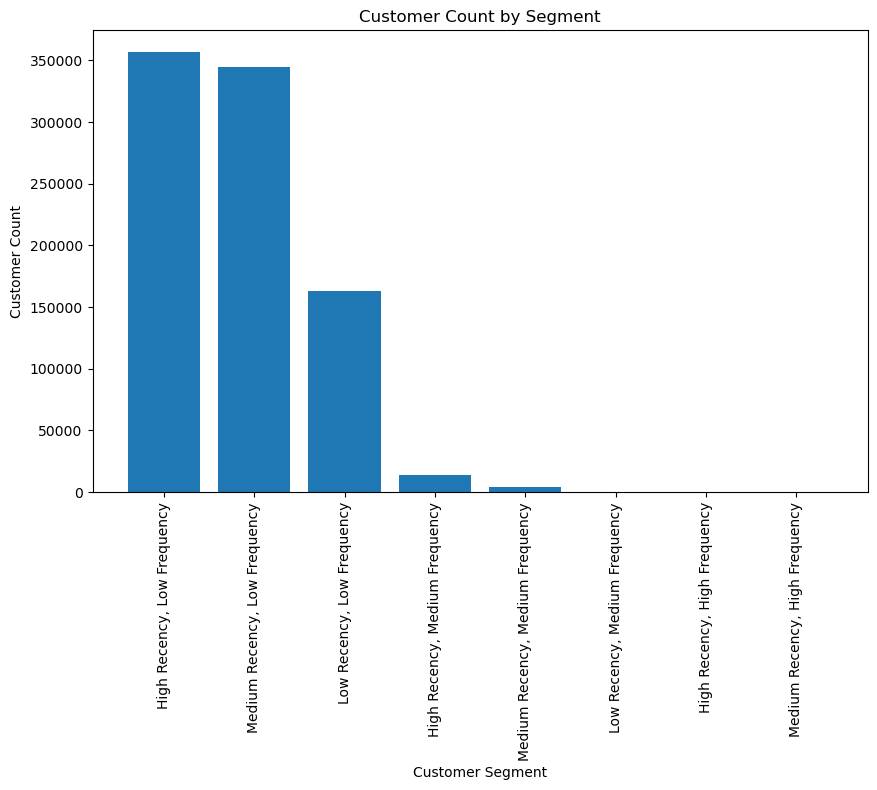

In [35]:
# Sort the values
dfUserSummary.sort_values(by='CustomerID', ascending=False, inplace=True)

# Creating a Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(dfUserSummary.index, dfUserSummary['CustomerID'])
plt.xlabel('Customer Segment')
plt.ylabel('Customer Count')
plt.title('Customer Count by Segment')
plt.xticks(rotation=90)
plt.show()

# **Review**
* Most customers exhibit low transaction frequency, which may pose challenges for the bank's sustainability.
  * Recommendation: Enhance customer engagement by improving customer service and actively seeking feedback. We may gain some understanding of what is holding them to do bank activities. In addition, banks can also innovate by creating digital bank features for more convenience banking experience.
* The Low Recency, Low Frequency Segment also looks concerning since it's our third highest customer segment. 
  * Recommendation: It's crucial to re-engage with these customers and remind them of the benefits and services the bank offers. Develop reactivation campaigns or special offers to entice them to return and increase their interaction levels.
